# Model Explainability and Regulation: SHAP and LIME

This hands-on lab demonstrates key concepts in machine learning model interpretability and explainability using real-world data. We'll cover:

1. **Introduction to Model Interpretability** - Understanding the need for explainable AI
2. **SHAP (SHapley Additive exPlanations)** - Theory and practical implementation
3. **LIME (Local Interpretable Model-agnostic Explanations)** - Local explanations for individual predictions
4. **Regulatory Considerations for AI Models** - Compliance, fairness, and transparency

## Dataset

We'll use the **Adult Income Dataset** (also known as Census Income dataset) from UCI Machine Learning Repository. This dataset is perfect for demonstrating explainability in a regulatory context as it involves sensitive attributes and predictions that affect people's lives.

**Task**: Predict whether a person makes over $50K a year based on census data.

**Why this dataset?**
- Real-world use case (credit scoring, hiring decisions)
- Contains sensitive attributes (age, sex, race, education)
- Regulatory implications for fairness and non-discrimination
- Interpretable features for clear explanations

## Setup and Data Loading

First, let's import all necessary libraries and load our dataset.

In [1]:
!uv pip install pandas scikit-learn matplotlib numpy shap lime

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Audited 6 packages in 24ms


In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Explainability libraries
import shap
from lime import lime_tabular

# Set random seed for reproducibility
np.random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")
print(f"SHAP version: {shap.__version__}")

✓ Libraries imported successfully
SHAP version: 0.49.1


### Load and Explore the Adult Income Dataset

We'll load the dataset directly from UCI's repository. The dataset contains demographic and employment information.

In [3]:
# Column names for the Adult dataset
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load data from UCI repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (32561, 15)

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Basic information about the dataset
print("Dataset Information:")
print(f"Total samples: {len(df):,}")
print(f"Features: {len(df.columns) - 1}")
print(f"\nTarget distribution:")
print(df['income'].value_counts())
print(f"\nMissing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset Information:
Total samples: 32,561
Features: 14

Target distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Missing values per column:
Series([], dtype: int64)


## 1. Introduction to Model Interpretability

### Why Do We Need Explainable AI?

**Model interpretability** refers to the degree to which a human can understand the cause of a decision made by a machine learning model.

**Key Reasons:**
1. **Trust**: Stakeholders need to trust model predictions
2. **Debugging**: Understanding why a model makes certain predictions helps identify errors
3. **Regulatory Compliance**: Laws like GDPR, ECOA require explanations for automated decisions
4. **Fairness**: Detecting and mitigating bias in model predictions
5. **Scientific Understanding**: Learning new insights from model behavior

### Types of Interpretability

1. **Global Interpretability**: Understanding the overall model behavior
   - Which features are most important?
   - How do features interact?

2. **Local Interpretability**: Understanding individual predictions
   - Why did the model make this specific prediction?
   - Which features contributed most to this decision?

### The Tradeoff: Accuracy vs. Interpretability

- **Simple models** (Linear Regression, Decision Trees): Highly interpretable but may lack accuracy
- **Complex models** (Random Forests, XGBoost, Neural Networks): High accuracy but "black box"
- **Solution**: Use explainability tools (SHAP, LIME) to interpret complex models

## Data Preprocessing

Before building our model, we need to prepare the data by handling missing values and encoding categorical variables.

In [5]:
# Remove rows with missing values (simple approach for this demo)
df_clean = df.dropna()
print(f"Samples after removing missing values: {len(df_clean):,}")

# Create binary target variable
df_clean['income_binary'] = (df_clean['income'] == '>50K').astype(int)

# Select features for modeling
# We'll use a mix of numerical and categorical features
numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

# Create a copy for modeling
df_model = df_clean.copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Prepare feature matrix and target
feature_columns = numerical_features + categorical_features
X = df_model[feature_columns]
y = df_model['income_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures used: {len(feature_columns)}")
print(feature_columns)

Samples after removing missing values: 32,561

Training set: (26048, 12)
Test set: (6513, 12)

Features used: 12
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']


## Train a Machine Learning Model

We'll train a Random Forest classifier - a powerful but "black box" model that will benefit from explainability tools.

Training Random Forest model...

Model Performance
Accuracy: 0.8629

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.96      0.91      4945
        >50K       0.80      0.57      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.84      0.76      0.79      6513
weighted avg       0.86      0.86      0.85      6513



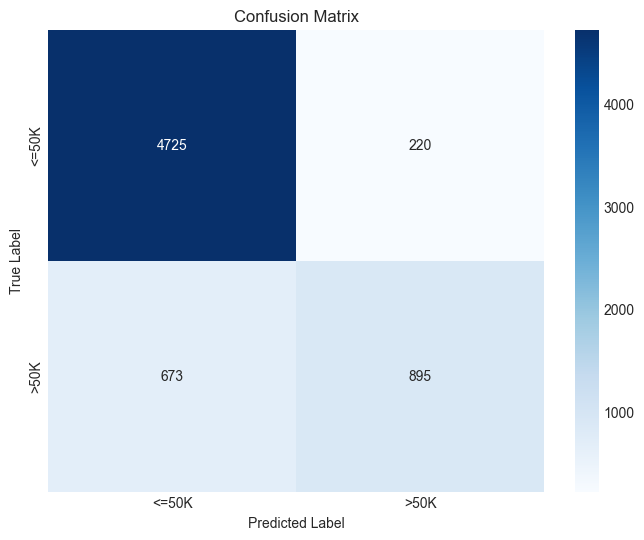

In [6]:
# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest model...")
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*60}")
print(f"Model Performance")
print(f"{'='*60}")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 2. SHAP (SHapley Additive exPlanations)

### What is SHAP?

SHAP is based on **Shapley values** from cooperative game theory. It provides a unified measure of feature importance that:

- **Is theoretically grounded**: Based on solid mathematical foundations
- **Is consistent**: If a model changes so a feature has a larger impact, the importance should increase
- **Is locally accurate**: The sum of feature attributions equals the model output
- **Works globally and locally**: Provides both instance-level and global explanations

### How SHAP Works

SHAP values represent the contribution of each feature to the prediction, compared to the average prediction:

```
prediction = base_value + Σ(SHAP_value_i)
```

For each feature:
- **Positive SHAP value**: Feature pushes prediction higher
- **Negative SHAP value**: Feature pushes prediction lower
- **Magnitude**: How much the feature contributed

In [17]:
# Create SHAP explainer for our Random Forest model
print("Creating SHAP TreeExplainer...")
print("(This may take a moment for large datasets)")

# Use a subset for faster computation in this demo
X_test_sample = X_test.sample(n=min(1000, len(X_test)), random_state=42)

# TreeExplainer is optimized for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

print("✓ SHAP values computed")
print(f"Shape: {np.array(shap_values).shape}")

# Handle different SHAP return formats
if isinstance(shap_values, list):
    # Old format: list of arrays
    shap_values_class1 = shap_values[1]
else:
    # New format: 3D array (n_samples, n_features, n_classes)
    shap_values_class1 = shap_values[:, :, 1]

Creating SHAP TreeExplainer...
(This may take a moment for large datasets)
✓ SHAP values computed
Shape: (1000, 12, 2)
✓ SHAP values computed
Shape: (1000, 12, 2)


### SHAP Summary Plot: Global Feature Importance

The summary plot shows:
- Features ranked by importance (top to bottom)
- Distribution of SHAP values for each feature
- Color indicates feature value (red = high, blue = low)

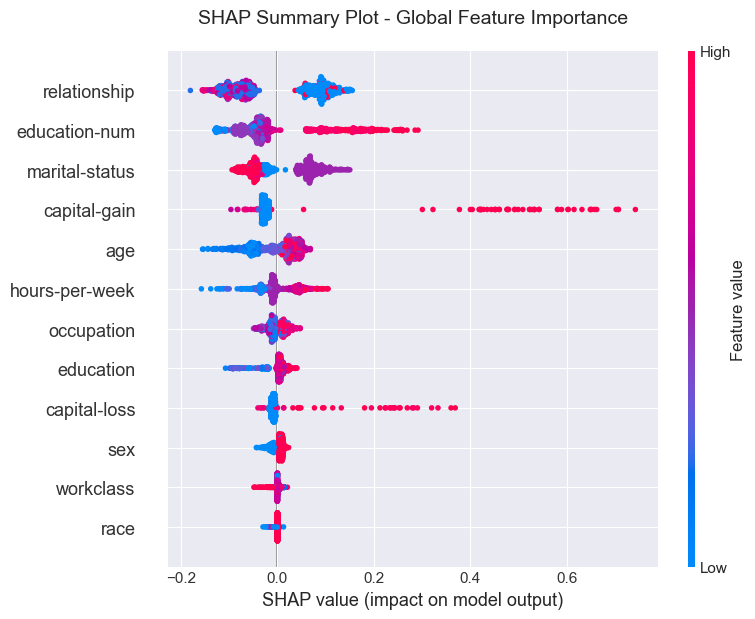


Interpretation:
- Each dot is a person in the dataset
- X-axis shows SHAP value (impact on prediction)
- Color shows feature value (red=high, blue=low)
- Features sorted by importance (top = most important)


In [28]:
# Global feature importance visualization
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, feature_names=feature_columns, show=False)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each dot is a person in the dataset")
print("- X-axis shows SHAP value (impact on prediction)")
print("- Color shows feature value (red=high, blue=low)")
print("- Features sorted by importance (top = most important)")

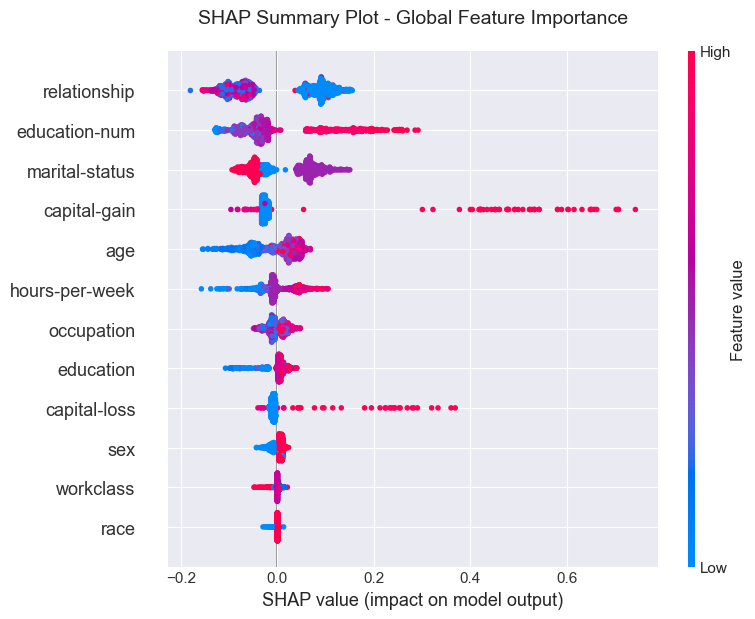


Interpretation:
- Each dot is a person in the dataset
- X-axis shows SHAP value (impact on prediction)
- Color shows feature value (red=high, blue=low)
- Features sorted by importance (top = most important)


In [24]:
# Global feature importance visualization
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, feature_names=feature_columns, show=False)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each dot is a person in the dataset")
print("- X-axis shows SHAP value (impact on prediction)")
print("- Color shows feature value (red=high, blue=low)")
print("- Features sorted by importance (top = most important)")

In [25]:
# Debug: Check shapes before plotting
print("Debugging shapes:")
print(f"X_test_sample.shape: {X_test_sample.shape}")
print(f"shap_values shape: {np.array(shap_values).shape}")
print(f"shap_values[1] shape: {shap_values[1].shape}")
print(f"len(feature_columns): {len(feature_columns)}")
print(f"feature_columns: {feature_columns}")

Debugging shapes:
X_test_sample.shape: (1000, 12)
shap_values shape: (1000, 12, 2)
shap_values[1] shape: (12, 2)
len(feature_columns): 12
feature_columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']


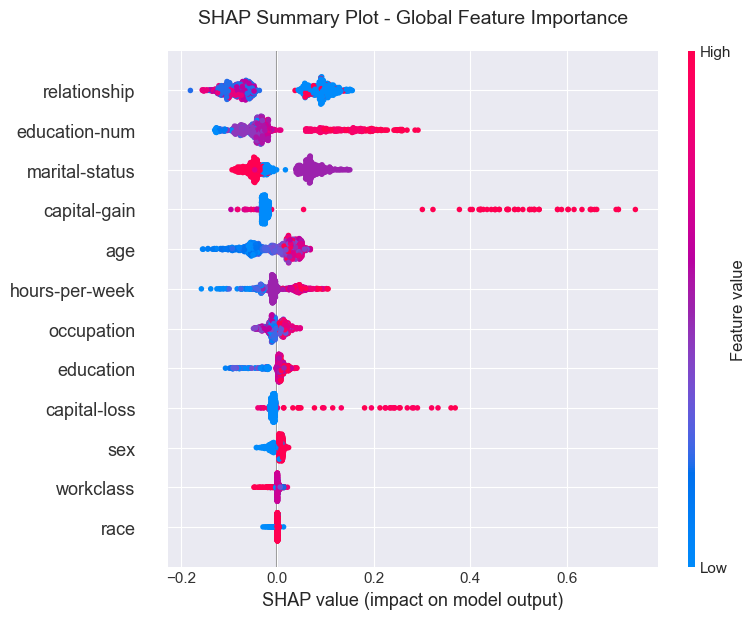


Interpretation:
- Each dot is a person in the dataset
- X-axis shows SHAP value (impact on prediction)
- Color shows feature value (red=high, blue=low)
- Features sorted by importance (top = most important)


In [26]:
# Global feature importance visualization
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, feature_names=feature_columns, show=False)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each dot is a person in the dataset")
print("- X-axis shows SHAP value (impact on prediction)")
print("- Color shows feature value (red=high, blue=low)")
print("- Features sorted by importance (top = most important)")

Debugging shapes:
X_test_sample.shape: (1000, 12)
shap_values shape: (1000, 12, 2)
shap_values[1] shape: (12, 2)
len(feature_columns): 12
feature_columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']


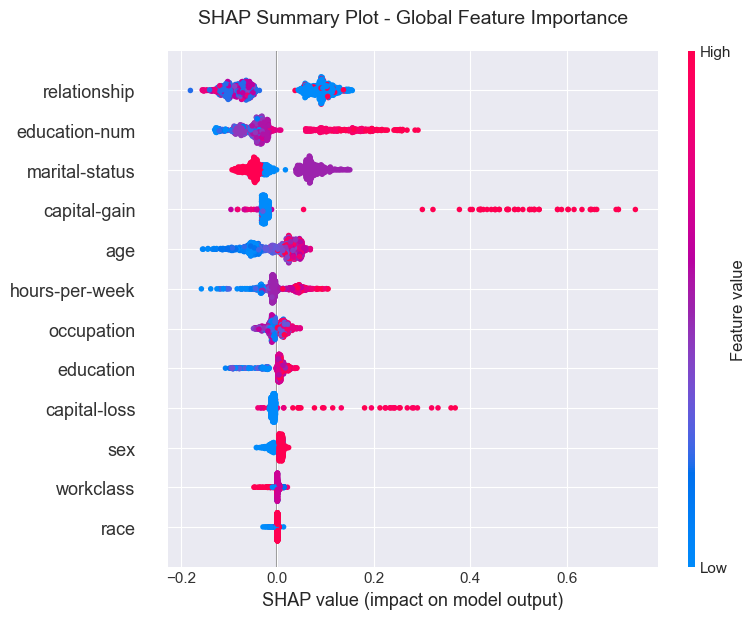

In [27]:
# Debug: Check shapes before plotting
print("Debugging shapes:")
print(f"X_test_sample.shape: {X_test_sample.shape}")
print(f"shap_values shape: {np.array(shap_values).shape}")
print(f"shap_values[1] shape: {shap_values[1].shape}")
print(f"len(feature_columns): {len(feature_columns)}")
print(f"feature_columns: {feature_columns}")

# Global feature importance visualization
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, feature_names=feature_columns, show=False)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### SHAP Bar Plot: Mean Absolute Feature Importance

This shows the average magnitude of each feature's impact across all predictions.

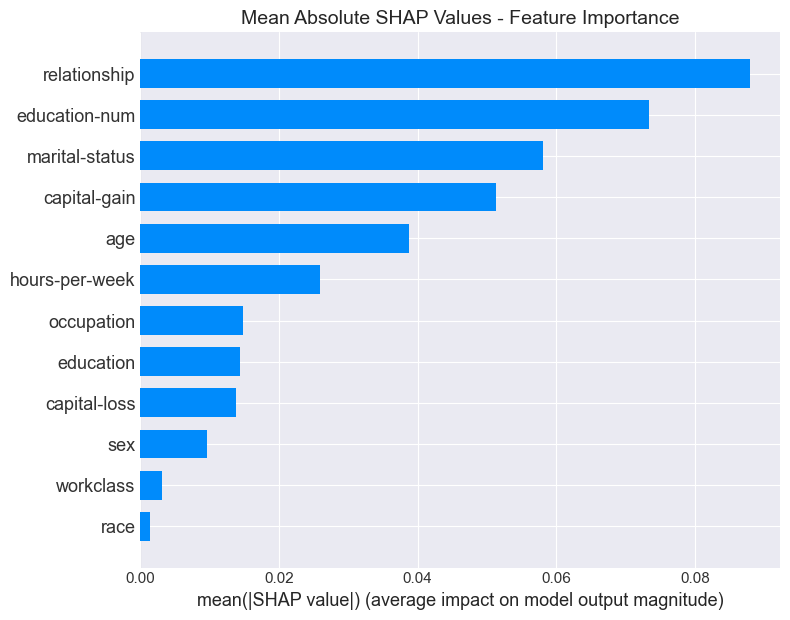


Top 10 Most Important Features:
       Feature  Mean |SHAP|
  relationship     0.087869
 education-num     0.073404
marital-status     0.058101
  capital-gain     0.051299
           age     0.038753
hours-per-week     0.025969
    occupation     0.014796
     education     0.014325
  capital-loss     0.013853
           sex     0.009679


In [29]:
# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", 
                  feature_names=feature_columns, show=False)
plt.title('Mean Absolute SHAP Values - Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()

# Calculate and display numerical importance
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

### SHAP Force Plot: Explaining Individual Predictions

Force plots show how each feature contributes to pushing a specific prediction away from the base value (average prediction).

- **Red arrows**: Push prediction higher (toward >50K)
- **Blue arrows**: Push prediction lower (toward <=50K)

In [30]:
# Initialize SHAP JavaScript visualization
shap.initjs()

# Explain a specific prediction
sample_idx = 0
sample_prediction = model.predict_proba(X_test_sample.iloc[[sample_idx]])[0]

print(f"Explaining prediction for sample {sample_idx}")
print(f"Predicted probability of >50K: {sample_prediction[1]:.4f}")
print(f"Actual label: {'Positive' if y_test.iloc[X_test_sample.index[sample_idx]] == 1 else 'Negative'}")

# Display the force plot
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[sample_idx],
    X_test_sample.iloc[sample_idx],
    feature_names=feature_columns
)

Explaining prediction for sample 0
Predicted probability of >50K: 0.3906
Actual label: Negative


### Detailed Local Explanation

Let's create a detailed breakdown of what contributes to a specific prediction.

In [31]:
# Create detailed explanation for a sample
def explain_prediction_detailed(model, X_sample, shap_values, feature_names, sample_idx=0):
    """
    Provide a detailed textual explanation of a prediction.
    """
    prediction = model.predict_proba(X_sample.iloc[[sample_idx]])[0]
    shap_vals = shap_values[sample_idx]
    feature_vals = X_sample.iloc[sample_idx]
    
    # Create explanation dataframe
    explanation = pd.DataFrame({
        'Feature': feature_names,
        'Value': feature_vals.values,
        'SHAP Value': shap_vals,
        'Abs SHAP': np.abs(shap_vals)
    }).sort_values('Abs SHAP', ascending=False)
    
    print("="*80)
    print(f"DETAILED EXPLANATION FOR PREDICTION")
    print("="*80)
    print(f"\nPredicted Probabilities:")
    print(f"  Income <=50K: {prediction[0]:.2%}")
    print(f"  Income >50K:  {prediction[1]:.2%}")
    print(f"\nPrediction: {'Income >50K' if prediction[1] > 0.5 else 'Income <=50K'}")
    
    print(f"\n{'Feature':<20} {'Value':<15} {'SHAP Impact':<15} {'Direction'}")
    print("-"*80)
    
    for idx, row in explanation.head(10).iterrows():
        direction = "↑ (Higher income)" if row['SHAP Value'] > 0 else "↓ (Lower income)"
        print(f"{row['Feature']:<20} {str(row['Value']):<15} {row['SHAP Value']:>10.4f}     {direction}")
    
    return explanation

# Explain the first sample
explanation_df = explain_prediction_detailed(
    model, X_test_sample, shap_values_class1, feature_columns, sample_idx=0
)

DETAILED EXPLANATION FOR PREDICTION

Predicted Probabilities:
  Income <=50K: 60.94%
  Income >50K:  39.06%

Prediction: Income <=50K

Feature              Value           SHAP Impact     Direction
--------------------------------------------------------------------------------
relationship         0                   0.0969     ↑ (Higher income)
education-num        9                  -0.0832     ↓ (Lower income)
marital-status       2                   0.0614     ↑ (Higher income)
hours-per-week       60                  0.0500     ↑ (Higher income)
age                  51                  0.0482     ↑ (Higher income)
capital-gain         0                  -0.0296     ↓ (Lower income)
capital-loss         0                  -0.0109     ↓ (Lower income)
sex                  1                   0.0095     ↑ (Higher income)
education            11                  0.0060     ↑ (Higher income)
workclass            2                   0.0056     ↑ (Higher income)


### SHAP Dependence Plots: Feature Interactions

Dependence plots show how a single feature's value affects predictions, potentially revealing interactions with other features.

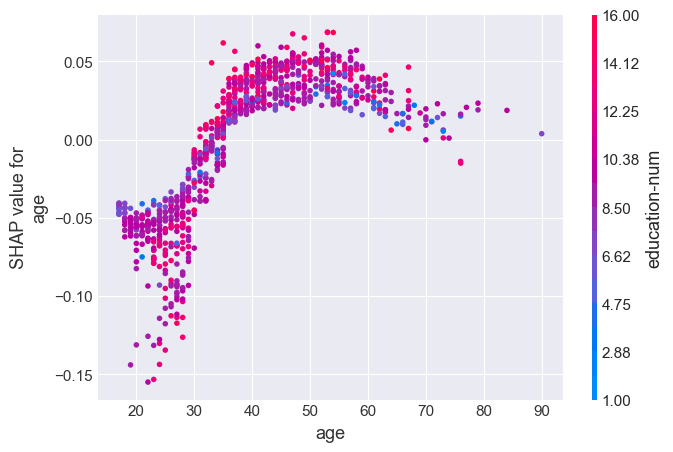

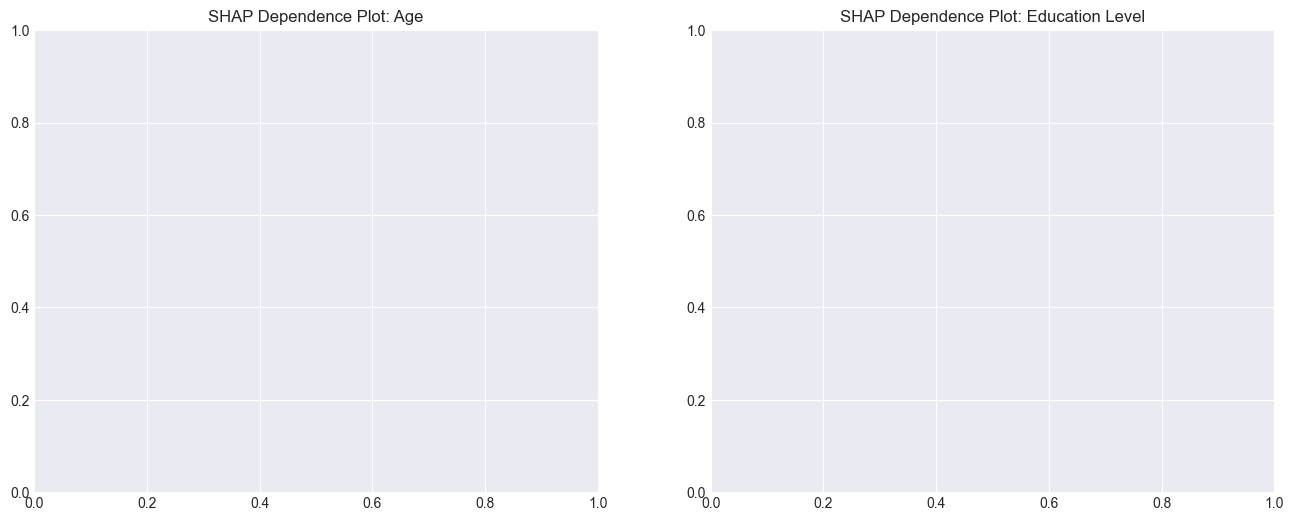

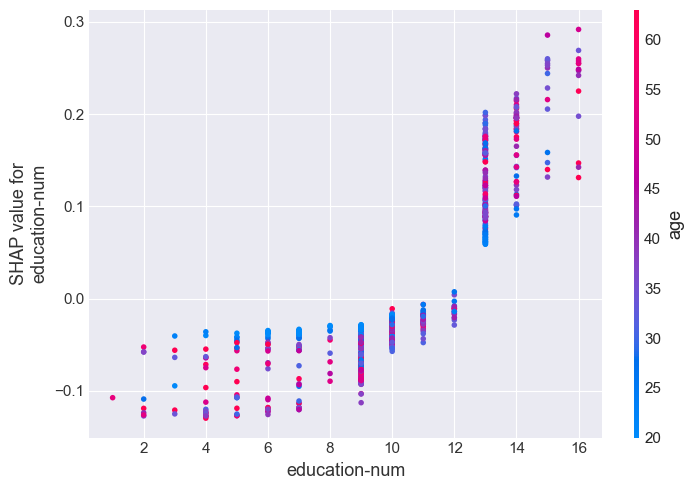


Interpretation:
- X-axis: Feature value
- Y-axis: SHAP value (impact on prediction)
- Color: Interaction feature value
- Shows how feature effect changes with its value and interactions


In [32]:
# Dependence plot for age (most important feature)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Age dependence
plt.sca(axes[0])
shap.dependence_plot(
    'age',
    shap_values_class1,
    X_test_sample,
    feature_names=feature_columns,
    interaction_index='education-num',
    show=False
)
axes[0].set_title('SHAP Dependence Plot: Age', fontsize=12)

# Education dependence
plt.sca(axes[1])
shap.dependence_plot(
    'education-num',
    shap_values_class1,
    X_test_sample,
    feature_names=feature_columns,
    interaction_index='age',
    show=False
)
axes[1].set_title('SHAP Dependence Plot: Education Level', fontsize=12)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- X-axis: Feature value")
print("- Y-axis: SHAP value (impact on prediction)")
print("- Color: Interaction feature value")
print("- Shows how feature effect changes with its value and interactions")

## 3. LIME (Local Interpretable Model-agnostic Explanations)

### What is LIME?

LIME explains individual predictions by:
1. **Perturbing** the input (creating similar samples)
2. **Getting predictions** from the complex model for these samples
3. **Training a simple model** (like linear regression) on these perturbed samples
4. **Using the simple model** to explain the prediction

### Key Concepts

- **Model-agnostic**: Works with any ML model (black box)
- **Local fidelity**: Approximates the model locally around the instance
- **Interpretable**: Uses interpretable representations (linear models)

### LIME vs SHAP

| Aspect | LIME | SHAP |
|--------|------|------|
| Foundation | Perturbation-based | Game theory (Shapley values) |
| Scope | Local only | Local + Global |
| Speed | Fast | Slower (especially KernelSHAP) |
| Consistency | May vary | Consistent and unique |
| Use Case | Quick explanations | Thorough analysis |

In [33]:
# Create LIME explainer
print("Creating LIME explainer...")

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_columns,
    class_names=['<=50K', '>50K'],
    mode='classification',
    random_state=42
)

print("✓ LIME explainer created")

Creating LIME explainer...
✓ LIME explainer created


### LIME: Explaining Individual Predictions

Let's explain the same prediction we analyzed with SHAP to compare the approaches.

In [34]:
# Explain a single instance with LIME
sample_idx = 0
instance = X_test_sample.iloc[sample_idx].values

print("Generating LIME explanation...")
lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=10
)

# Display explanation
print("\n" + "="*80)
print("LIME EXPLANATION")
print("="*80)

# Get prediction
prediction = model.predict_proba(instance.reshape(1, -1))[0]
print(f"\nPredicted Probabilities:")
print(f"  Income <=50K: {prediction[0]:.2%}")
print(f"  Income >50K:  {prediction[1]:.2%}")

# Show the explanation as a list
print(f"\nTop Contributing Features:")
print(f"{'Feature Rule':<40} {'Weight':<15} {'Direction'}")
print("-"*80)

for feature, weight in lime_exp.as_list()[:10]:
    direction = "→ Higher income" if weight > 0 else "→ Lower income"
    print(f"{feature:<40} {weight:>10.4f}     {direction}")

Generating LIME explanation...

LIME EXPLANATION

Predicted Probabilities:
  Income <=50K: 60.94%
  Income >50K:  39.06%

Top Contributing Features:
Feature Rule                             Weight          Direction
--------------------------------------------------------------------------------
capital-gain <= 0.00                        -0.5528     → Lower income
education-num <= 9.00                       -0.1094     → Lower income
relationship <= 0.00                         0.1011     → Higher income
hours-per-week > 45.00                       0.0840     → Higher income
capital-loss <= 0.00                        -0.0744     → Lower income
marital-status <= 2.00                       0.0697     → Higher income
age > 48.00                                  0.0383     → Higher income
0.00 < sex <= 1.00                           0.0189     → Higher income
occupation > 10.00                           0.0166     → Higher income
9.00 < education <= 11.00                    0.0022     → 

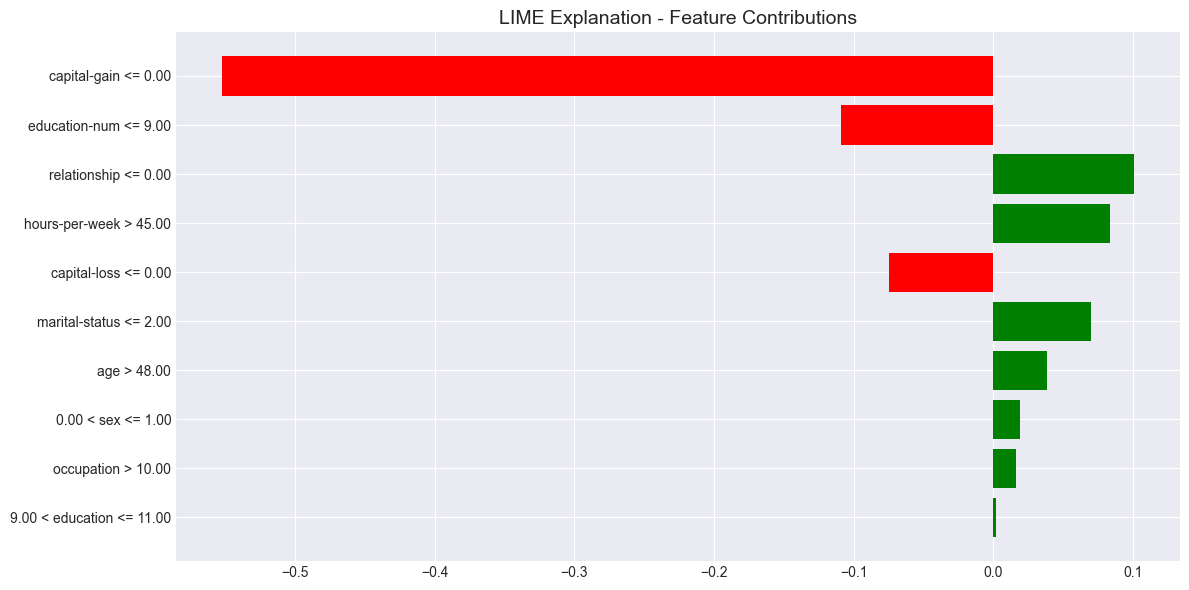


Interpretation:
- Green bars: Features pushing toward >50K income
- Red bars: Features pushing toward <=50K income
- Bar length: Magnitude of contribution


In [35]:
# Visualize LIME explanation
fig = lime_exp.as_pyplot_figure()
plt.title('LIME Explanation - Feature Contributions', fontsize=14)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Green bars: Features pushing toward >50K income")
print("- Red bars: Features pushing toward <=50K income")
print("- Bar length: Magnitude of contribution")

### Comparing Multiple LIME Explanations

Let's examine how LIME explains different types of predictions.

In [36]:
# Explain multiple instances
def compare_lime_explanations(model, X_data, lime_explainer, n_samples=3):
    """
    Compare LIME explanations for multiple predictions.
    """
    for i in range(n_samples):
        instance = X_data.iloc[i].values
        prediction = model.predict_proba(instance.reshape(1, -1))[0]
        
        print("\n" + "="*80)
        print(f"SAMPLE {i+1}")
        print("="*80)
        print(f"Predicted: {'Income >50K' if prediction[1] > 0.5 else 'Income <=50K'}")
        print(f"Confidence: {max(prediction):.2%}")
        
        # Generate explanation
        exp = lime_explainer.explain_instance(
            data_row=instance,
            predict_fn=model.predict_proba,
            num_features=5
        )
        
        print(f"\nTop 5 Features:")
        for feature, weight in exp.as_list()[:5]:
            print(f"  {feature}: {weight:+.4f}")

# Compare explanations
compare_lime_explanations(model, X_test_sample, lime_explainer, n_samples=3)


SAMPLE 1
Predicted: Income <=50K
Confidence: 60.94%

Top 5 Features:
  capital-gain <= 0.00: -0.5679
  education-num <= 9.00: -0.1096
  relationship <= 0.00: +0.1042
  hours-per-week > 45.00: +0.0807
  marital-status <= 2.00: +0.0701

SAMPLE 2
Predicted: Income <=50K
Confidence: 99.85%

Top 5 Features:
  capital-gain <= 0.00: -0.5552
  education-num <= 9.00: -0.1054
  age <= 28.00: -0.0738
  hours-per-week <= 40.00: -0.0713
  2.00 < marital-status <= 4.00: -0.0696

SAMPLE 3
Predicted: Income <=50K
Confidence: 50.39%

Top 5 Features:
  capital-gain <= 0.00: -0.5671
  relationship <= 0.00: +0.0989
  hours-per-week > 45.00: +0.0781
  marital-status <= 2.00: +0.0689
  37.00 < age <= 48.00: +0.0416

SAMPLE 3
Predicted: Income <=50K
Confidence: 50.39%

Top 5 Features:
  capital-gain <= 0.00: -0.5671
  relationship <= 0.00: +0.0989
  hours-per-week > 45.00: +0.0781
  marital-status <= 2.00: +0.0689
  37.00 < age <= 48.00: +0.0416


### SHAP vs LIME: Side-by-Side Comparison

Let's compare both methods on the same prediction.

In [37]:
# Compare SHAP and LIME for the same instance
def compare_shap_lime(model, X_sample, shap_vals, lime_explainer, feature_names, idx=0):
    """
    Compare SHAP and LIME explanations side by side.
    """
    instance = X_sample.iloc[idx].values
    prediction = model.predict_proba(instance.reshape(1, -1))[0]
    
    print("="*80)
    print("SHAP vs LIME COMPARISON")
    print("="*80)
    print(f"\nPrediction: {'Income >50K' if prediction[1] > 0.5 else 'Income <=50K'}")
    print(f"Probability: {prediction[1]:.2%}")
    
    # SHAP explanation
    shap_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP': shap_vals[idx],
        'Abs_SHAP': np.abs(shap_vals[idx])
    }).sort_values('Abs_SHAP', ascending=False)
    
    # LIME explanation
    lime_exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=model.predict_proba,
        num_features=len(feature_names)
    )
    
    lime_dict = dict(lime_exp.as_list())
    
    print(f"\n{'Feature':<20} {'SHAP Value':<15} {'LIME Weight':<15} {'Agreement'}")
    print("-"*80)
    
    for _, row in shap_importance.head(8).iterrows():
        feature = row['Feature']
        shap_val = row['SHAP']
        
        # Find corresponding LIME value (approximate match)
        lime_val = 0
        for lime_feature, lime_weight in lime_dict.items():
            if feature in lime_feature:
                lime_val = lime_weight
                break
        
        # Check if both agree on direction
        agreement = "✓" if (shap_val * lime_val) > 0 else "✗"
        
        print(f"{feature:<20} {shap_val:>10.4f}      {lime_val:>10.4f}      {agreement}")
    
    print("\nKey Observations:")
    print("✓ = Both methods agree on direction (positive or negative impact)")
    print("✗ = Methods disagree on direction")

# Run comparison
compare_shap_lime(model, X_test_sample, shap_values_class1, lime_explainer, feature_columns, idx=0)

SHAP vs LIME COMPARISON

Prediction: Income <=50K
Probability: 39.06%

Feature              SHAP Value      LIME Weight     Agreement
--------------------------------------------------------------------------------
relationship             0.0969          0.0990      ✓
education-num           -0.0832         -0.1063      ✓
marital-status           0.0614          0.0695      ✓
hours-per-week           0.0500          0.0778      ✓
age                      0.0482          0.0419      ✓
capital-gain            -0.0296         -0.5596      ✓
capital-loss            -0.0109         -0.0986      ✓
sex                      0.0095          0.0152      ✓

Key Observations:
✓ = Both methods agree on direction (positive or negative impact)
✗ = Methods disagree on direction


## 4. Regulatory Considerations for AI Models

### Why Regulation Matters

Machine learning models increasingly make decisions that significantly impact people's lives:
- Credit approval/denial
- Hiring decisions
- Insurance pricing
- Healthcare diagnoses
- Criminal justice (bail, sentencing)

### Key Regulatory Frameworks

1. **GDPR (General Data Protection Regulation) - EU**
   - Right to explanation for automated decisions
   - Data protection and privacy requirements
   - Affects any organization handling EU citizen data

2. **ECOA (Equal Credit Opportunity Act) - US**
   - Requires explanation for credit denials
   - Adverse action notices
   - Prohibits discrimination

3. **Fair Lending Laws**
   - Prohibit discrimination based on protected attributes
   - Require fair treatment across demographics

4. **Proposed AI Regulations**
   - EU AI Act (risk-based approach)
   - US Algorithmic Accountability Act
   - Various state-level regulations

### Protected Attributes

These attributes cannot be used for discriminatory decisions:
- Race/Ethnicity
- Sex/Gender
- Age
- Religion
- National Origin
- Disability Status
- Marital Status

### Fairness Analysis: Detecting Bias

Let's examine if our model treats different demographic groups fairly.

In [38]:
# Analyze model fairness across protected attributes
def analyze_fairness(model, X_data, y_true, df_original, feature_columns):
    """
    Analyze model predictions across demographic groups.
    """
    # Get predictions
    y_pred = model.predict(X_data)
    y_pred_proba = model.predict_proba(X_data)[:, 1]
    
    # Create analysis dataframe
    analysis_df = pd.DataFrame({
        'prediction': y_pred,
        'probability': y_pred_proba,
        'actual': y_true.values
    })
    
    # Add demographic information
    # Get sex information (assuming it's encoded)
    sex_idx = feature_columns.index('sex')
    analysis_df['sex'] = X_data.iloc[:, sex_idx].values
    
    print("="*80)
    print("FAIRNESS ANALYSIS")
    print("="*80)
    
    # Analyze by sex
    print("\nPredictions by Sex:")
    sex_analysis = analysis_df.groupby('sex').agg({
        'prediction': ['count', 'mean'],
        'probability': 'mean',
        'actual': 'mean'
    })
    sex_analysis.columns = ['Count', 'Predicted >50K Rate', 'Avg Probability', 'Actual >50K Rate']
    print(sex_analysis)
    
    # Statistical parity difference
    rates = analysis_df.groupby('sex')['prediction'].mean()
    if len(rates) == 2:
        spd = rates.iloc[1] - rates.iloc[0]
        print(f"\nStatistical Parity Difference: {spd:.4f}")
        print("(Difference in positive prediction rates between groups)")
        print("Ideally should be close to 0 for fairness")
    
    return analysis_df

# Run fairness analysis
fairness_results = analyze_fairness(model, X_test_sample, 
                                    y_test.loc[X_test_sample.index], 
                                    df_clean, feature_columns)

FAIRNESS ANALYSIS

Predictions by Sex:
     Count  Predicted >50K Rate  Avg Probability  Actual >50K Rate
sex                                                               
0      329             0.075988         0.128639          0.130699
1      671             0.220566         0.307527          0.317437

Statistical Parity Difference: 0.1446
(Difference in positive prediction rates between groups)
Ideally should be close to 0 for fairness


### Using SHAP for Bias Detection

SHAP can help identify if protected attributes unfairly influence predictions.

In [39]:
# Analyze SHAP values for protected attributes
protected_features = ['sex', 'race', 'age']

print("="*80)
print("PROTECTED ATTRIBUTE IMPACT ANALYSIS")
print("="*80)

# Calculate mean absolute SHAP values for protected features
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
all_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Mean |SHAP|': mean_abs_shap,
    'Rank': range(1, len(feature_columns) + 1)
}).sort_values('Mean |SHAP|', ascending=False)
all_importance_df['Rank'] = range(1, len(all_importance_df) + 1)

print("\nProtected Attribute Importance:")
print(f"{'Feature':<20} {'Mean |SHAP|':<15} {'Rank':<10} {'Status'}")
print("-"*80)

for feature in protected_features:
    if feature in all_importance_df['Feature'].values:
        row = all_importance_df[all_importance_df['Feature'] == feature].iloc[0]
        importance = row['Mean |SHAP|']
        rank = row['Rank']
        status = "⚠ HIGH" if rank <= 5 else "✓ Low" if rank > 10 else "~ Medium"
        print(f"{feature:<20} {importance:<15.4f} {rank:<10} {status}")

print("\nRecommendations:")
print("1. High importance for protected attributes may indicate potential bias")
print("2. Consider if this importance is justified by legitimate business needs")
print("3. May need to implement fairness constraints or preprocessing")
print("4. Document decision-making process for regulatory compliance")

PROTECTED ATTRIBUTE IMPACT ANALYSIS

Protected Attribute Importance:
Feature              Mean |SHAP|     Rank       Status
--------------------------------------------------------------------------------
sex                  0.0097          10         ~ Medium
race                 0.0013          12         ✓ Low
age                  0.0388          5          ⚠ HIGH

Recommendations:
1. High importance for protected attributes may indicate potential bias
2. Consider if this importance is justified by legitimate business needs
3. May need to implement fairness constraints or preprocessing
4. Document decision-making process for regulatory compliance


### Best Practices for Regulatory Compliance

#### 1. Documentation Requirements

Maintain comprehensive documentation:
- Model development process
- Training data sources and characteristics
- Feature selection rationale
- Validation and testing procedures
- Fairness assessments
- Ongoing monitoring procedures

#### 2. Explainability Requirements

Be able to explain:
- **Why**: Why did the model make this decision?
- **What**: What factors were most important?
- **How**: How do we ensure fairness?
- **When**: When should we update the model?

#### 3. Adverse Action Notices

For negative decisions (e.g., loan denial), provide:
- Primary reasons for the decision
- Specific factors that adversely affected the decision
- Clear, understandable language (not technical jargon)

#### 4. Human Oversight

- Ensure human review for high-stakes decisions
- Ability to override automated decisions
- Appeal process for affected individuals

#### 5. Monitoring and Auditing

- Regular fairness audits
- Performance monitoring across demographics
- Drift detection (data and concept drift)
- Incident response procedures

### Generating Adverse Action Explanations

Let's create a function that generates regulatory-compliant explanations for negative predictions.

In [40]:
def generate_adverse_action_notice(model, instance, shap_values, feature_names, top_n=4):
    """
    Generate a regulatory-compliant adverse action notice.
    
    This simulates what would be required under regulations like ECOA.
    """
    prediction = model.predict_proba(instance.reshape(1, -1))[0]
    
    # Only generate for negative predictions
    if prediction[1] >= 0.5:
        return "Approved - No adverse action notice required"
    
    # Get SHAP values for this instance
    # Negative SHAP values push toward negative prediction (<=50K)
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP': shap_values,
        'Value': instance
    })
    
    # Sort by SHAP value (most negative = most responsible for denial)
    shap_df['Abs_SHAP'] = np.abs(shap_df['SHAP'])
    top_factors = shap_df.nsmallest(top_n, 'SHAP')
    
    # Generate notice
    notice = []
    notice.append("="*80)
    notice.append("ADVERSE ACTION NOTICE")
    notice.append("="*80)
    notice.append("")
    notice.append("Your application for income classification has been DENIED.")
    notice.append("")
    notice.append("The primary factors that adversely affected your decision were:")
    notice.append("")
    
    # Map technical features to user-friendly descriptions
    feature_descriptions = {
        'age': 'Your age',
        'education-num': 'Your education level',
        'capital-gain': 'Your capital gains',
        'capital-loss': 'Your capital losses',
        'hours-per-week': 'Your hours worked per week',
        'marital-status': 'Your marital status',
        'occupation': 'Your occupation',
        'relationship': 'Your relationship status',
        'workclass': 'Your work class',
        'education': 'Your education'
    }
    
    for i, (_, row) in enumerate(top_factors.iterrows(), 1):
        feature = row['Feature']
        description = feature_descriptions.get(feature, feature)
        notice.append(f"{i}. {description}")
    
    notice.append("")
    notice.append("You have the right to:")
    notice.append("- Request additional information about this decision")
    notice.append("- Appeal this decision within 60 days")
    notice.append("- Request a free copy of any report used in this decision")
    notice.append("")
    notice.append("This decision was made using an automated system with human oversight.")
    notice.append("="*80)
    
    return "\n".join(notice)

# Example: Generate notice for a denied application
# Find a sample with negative prediction
for i in range(len(X_test_sample)):
    instance = X_test_sample.iloc[i].values
    prediction = model.predict_proba(instance.reshape(1, -1))[0]
    
    if prediction[1] < 0.5:  # Negative prediction
        notice = generate_adverse_action_notice(
            model, instance, shap_values_class1[i], feature_columns
        )
        print(notice)
        break

ADVERSE ACTION NOTICE

Your application for income classification has been DENIED.

The primary factors that adversely affected your decision were:

1. Your education level
2. Your capital gains
3. Your capital losses
4. race

You have the right to:
- Request additional information about this decision
- Appeal this decision within 60 days
- Request a free copy of any report used in this decision

This decision was made using an automated system with human oversight.


## Summary and Key Takeaways

### 1. Model Interpretability is Essential

- Not just a nice-to-have, but increasingly **required by law**
- Critical for trust, debugging, and fairness
- Must balance with model performance

### 2. SHAP Advantages

✅ **Theoretically grounded** (Shapley values)
✅ **Consistent and unique** explanations
✅ **Both global and local** interpretability
✅ **Handles feature interactions**
✅ **Fast for tree-based models** (TreeExplainer)

❌ Can be computationally expensive (KernelSHAP)
❌ May be complex to communicate to non-technical audiences

### 3. LIME Advantages

✅ **Model-agnostic** - works with any model
✅ **Fast and intuitive**
✅ **Simple to understand** (linear approximation)
✅ **Great for text and images**

❌ Local only (no global importance)
❌ Can vary across runs
❌ Limited feature interaction support

### 4. When to Use Each

**Use SHAP when:**
- You need theoretical guarantees
- Global feature importance is important
- Working with tree-based models
- Regulatory compliance requires rigorous explanations

**Use LIME when:**
- Need quick local explanations
- Working with text or image data
- Computational resources are limited
- Want simple, intuitive explanations

**Best Practice:** Use both for critical applications!

### 5. Regulatory Compliance Checklist

- [ ] Document model development process
- [ ] Assess and mitigate bias across protected groups
- [ ] Implement explainability (SHAP/LIME)
- [ ] Create adverse action notice process
- [ ] Establish human oversight procedures
- [ ] Set up monitoring and auditing
- [ ] Create appeal process
- [ ] Train staff on AI ethics and fairness

### 6. Future Considerations

As AI regulation evolves:
- Stay informed about new regulations (EU AI Act, etc.)
- Invest in fairness-aware ML techniques
- Build interpretability into your ML pipeline from day one
- Consider ethical implications beyond legal requirements

### Resources for Further Learning

- [SHAP Documentation](https://shap.readthedocs.io/)
- [LIME Documentation](https://lime-ml.readthedocs.io/)
- [Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/)
- [Fairlearn Library](https://fairlearn.org/)
- [EU AI Act](https://artificialintelligenceact.eu/)

## Exercises for Practice

Try these exercises to deepen your understanding:

1. **Compare different models**: Train a Gradient Boosting model and compare its SHAP explanations with the Random Forest

2. **Feature engineering**: Create interaction features (e.g., age × education) and see how they affect explanations

3. **Fairness improvement**: Try removing or down-weighting protected attributes and measure the impact on fairness metrics

4. **Custom explanations**: Modify the adverse action notice generator to be more user-friendly

5. **Different datasets**: Apply SHAP and LIME to:
   - Healthcare data (e.g., diabetes prediction)
   - Credit scoring data
   - Your own domain-specific dataset

6. **Interaction analysis**: Use SHAP interaction values to find important feature pairs

7. **Stability analysis**: Run LIME multiple times on the same instance and measure explanation stability

In [41]:
# Your code for exercises here
